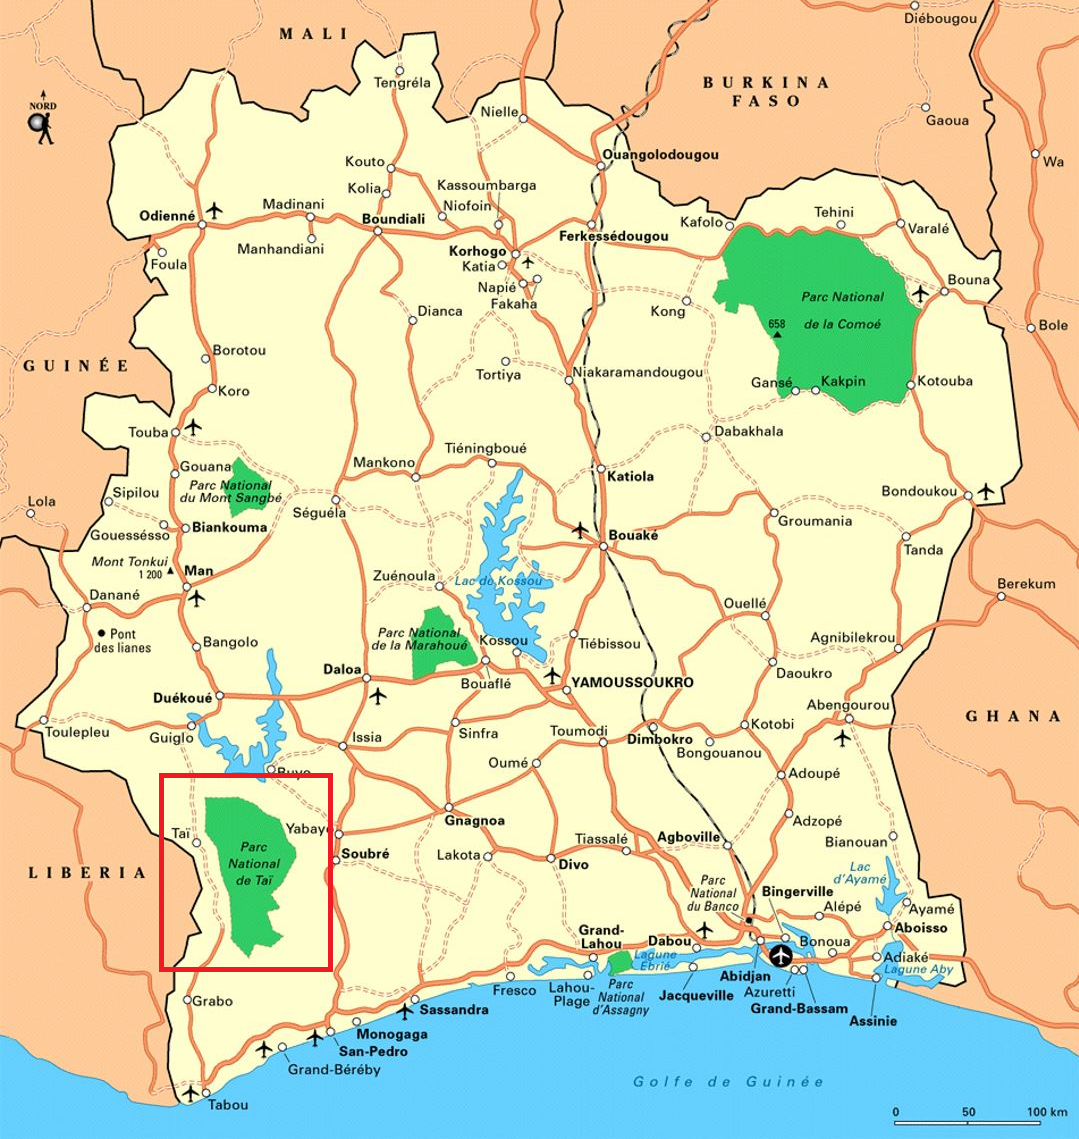

<b>Authors: Mackoy Staloch<b>

# Taï National Park: Using Machine Learning to Enchance Multi-Image Classification*

*For academic puroses only. I am not affiliated with Taï National Park.

## Introduction

For this capstone project, I worked with a hypothetical client Taï National Park to help analyze over 16,500 still images from 8 image classes to create a multi-image classification model that would help their researchers correctly identify the image class. With our analysis and modeling, our stakeholder Taï National Park can use our data driven insights to help identify poor performing camera traps and accurately identify local wildlife for their ebola virus research.

## Business Objective

With the number of photos that camera traps can take increasing as technology in the field gets better and better, it is more important than ever that NGOs and Research Organizations find ways to keep their scientists and researchers doing what they were hired to do. In the Taï National Parks case, they are studying the local Ebola Virus variant to find out how it came to the National Park and how it is transmitted. Through this image classification model, researchers will be heading towards a system where they can touch one button and sort through thousands of images accurately. This way they will be able to get back to their focus on discovering how Ebola came to be and how it transmits inside of Taï National Park.

# Data Understanding

In this jupyter notebook, I'll be taking a set of images and training different machine learning models on them to try and create a model that is better than the baseline model accuracy. To start off this process I will import the necessary packages and delve into the dataset in order to better understand it.

In [11]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
%matplotlib inline

In [12]:
# Reading in the csv's with the images
train_features = pd.read_csv("train_features.csv", index_col="id")
test_features = pd.read_csv("test_features.csv", index_col="id")
train_labels = pd.read_csv("train_labels.csv", index_col="id")

In [13]:
# Looking at our train_features dataset
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [14]:
# Looking at our test_features dataset
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


**train_features.csv** and **test_features.csv** both contain 3 columns, which are titled

- `id`
- `filepath`
- `site`

In [15]:
# Looking at our train_labels. These must be the animals we will be trying to classify
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# Creating a list of the column names so we can see the animals in the dataset as well for iteration purposes
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

**train_labels** contains 8 unique column types that have been dummied with a 1 or a 0 for their species type. (with the exception being blank, which represents an image without one of the species in it.)

- `antelope_duiker`
- `bird`
- `blank`
- `civet_genet`
- `hog`
- `leopard`
- `monkey_prosimian`
- `rodent`

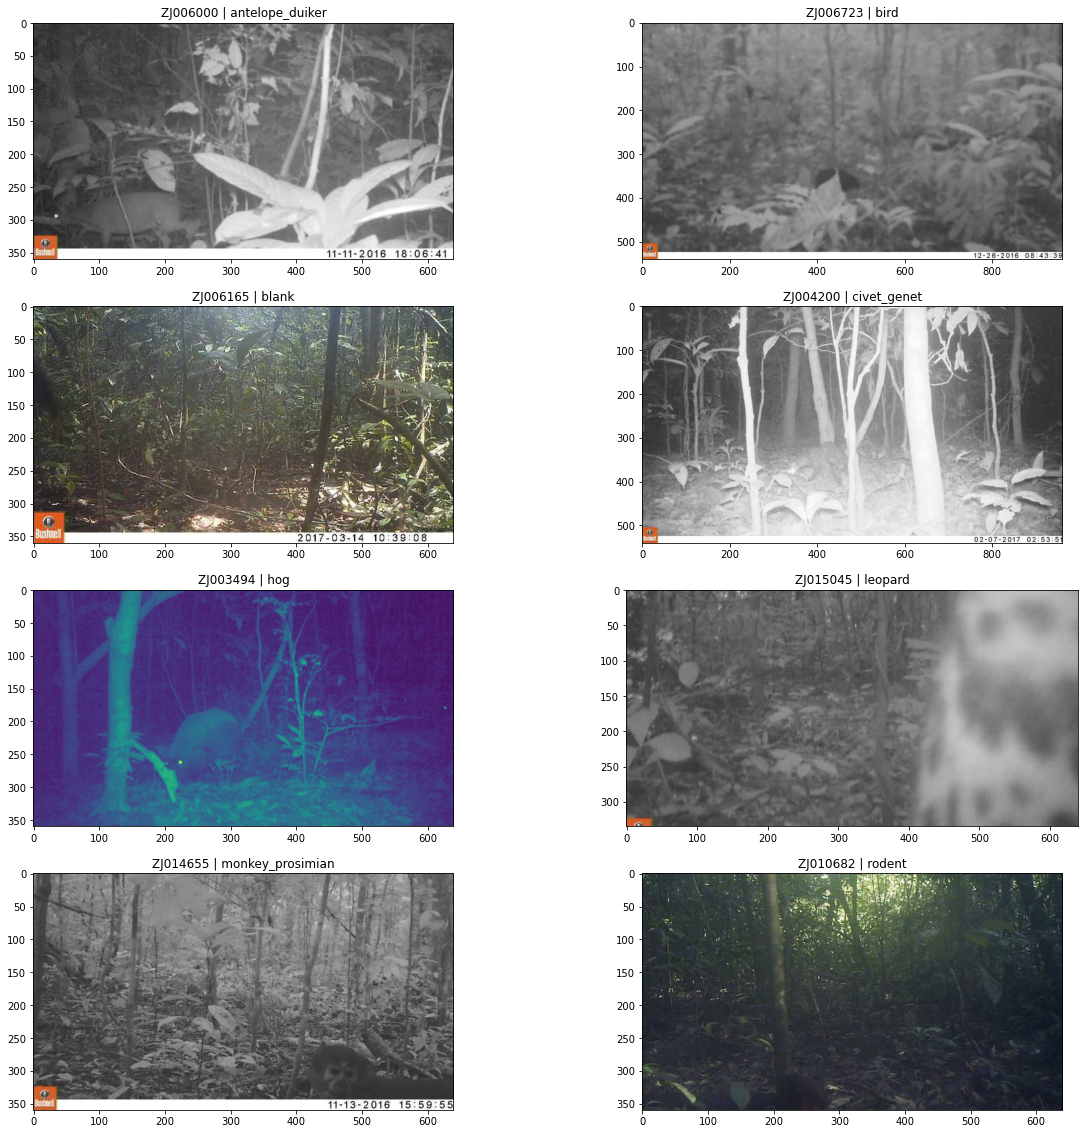

In [17]:
# we'll create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=42)
        .index[0]
    )
    # reads the filepath and returns a numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    # plot etc
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

A nice grid showing our 8 classification types. I'm starting to feel like the model might have a tough time picking up some of these images. Hopefully we can get the `blank` image types identified pretty well. At least filtering those out will save a lot of time for any researchers. 

Let's look into our dataset a little more to see if there are any null values and look at the breakdown of our images and labels.

In [18]:
# Looking at the number of images in our dataset
train_labels.sum().sum()

16488.0

In [19]:
# Taking a look at the distribution for animals in the images.
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [20]:
# Look at the percentage of animals in the dataset
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

In [15]:
# Making sure there are no null values
train_features.isna().sum()

filepath    0
site        0
dtype: int64

In [16]:
# Looks like all train_feature rows are unique
train_features.describe(include='O')

,filepath,site
count,16488,16488
unique,16488,148
top,train_features/ZJ007944.jpg,S0060
freq,1,1132


In [17]:
# Making sure there are no null values
test_features.isna().sum()

filepath    0
site        0
dtype: int64

In [18]:
# Looks like all test_feature rows are unique
test_features.describe(include='O')

,filepath,site
count,4464,4464
unique,4464,51
top,test_features/ZJ020479.jpg,S0040
freq,1,495


In [19]:
# Checking all rows to make sure there are no null values.
train_labels.isna().sum()

antelope_duiker     0
bird                0
blank               0
civet_genet         0
hog                 0
leopard             0
monkey_prosimian    0
rodent              0
dtype: int64

Overall, it looks like the breakdown is roughly similar between the image classes with there being `16488` images in total. There are no nulls and it looks like all images are unique with there being no duplicately named images in the set.

# Train-Test Split

Now that we've had a look at our dataset and understand that everything looks like it is in order, we can move on to the train-test split, which will have to be done in order to train our model. I'll make sure to stratify our train and test so that we can keep each of the 8 classes similarly weighted in our train and test sets. On top of this, I'll make sure to initiate a `random_state=42` for reproducibility.

In [21]:
# Setting up the train-test split
y = train_labels
x = train_features.loc[y.index].filepath.to_frame()

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, 
                                                    test_size=0.25, random_state=42)

In [22]:
# Sanity check
x_train.head()

,filepath
id,
ZJ013653,train_features/ZJ013653.jpg
ZJ012257,train_features/ZJ012257.jpg
ZJ013164,train_features/ZJ013164.jpg
ZJ013787,train_features/ZJ013787.jpg
ZJ002292,train_features/ZJ002292.jpg


In [23]:
# Sanity check
y_train.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ013653,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ012257,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
ZJ013164,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ013787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
ZJ002292,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [24]:
# Looks like everything matches up with our train-test split! Yay!
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12366, 1), (4122, 1), (12366, 8), (4122, 8))

Come back here if we want to try PyTorch splitting like they do in the baseline. At this point with my 2 previous capstone projects being dead ends with the first lacking data (after finding out how to import it from .netCDF4 to a .csv I saw that most of the rows were empty...) and the second lacking a proper business problem (after finding out that the image set was a multi-image classifcation for lemons with it being more than just a binary `health` and `not healthy`.) I decided to stick pretty close to the DataDriven labs process, with venturing out once I had a Minimum Viable Project.

# Modeling

## Baseline Model

Our baseline model for this image classification is going to be if we randomly guessed 1 of the animal classes for every image. This would give us an accuracy of 12.5% (1/8). We could also use the `monkey_prosimian    0.151140` as our baseline for a 15.11% accuracy. Let's try to imporove this by moving on to a simple logistic regression model.

# Initial Neural Net Model

This is a modification of the initial Nerual Net model used for the competition. We use 100% of the training data, with 75% being our train set and 25% being our test set. The goal of this section is to eventually find an accuracy for our modified model. In order to do this create a custome Dataset class that implements three functions `__init__`, `__getitem__`, and `__len__`. 

`__init__` initializes the directory containing the images, their annotation fiiles, and transforms them.

`__getitem__` converts the image location into a tensor and then retrieves the label for that image as well. This creates a tuple with the `image_id`, `image`, and `label`.

`__len__` returns the number of samples in our dataset.

In [25]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

This next step takes our recently created class and then iterates through our Dataset to make those changes.

In [26]:
# Importing the DataLoader tool for our dataset and applying it to our x_train and y_train
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

This next step is the fun part where we instantiate our model and then apply a few features to it to try and reduce the amount that it will overfit. (Which Neural Nets are notorious for doing.)

In [27]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

C:\Users\Coldk\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Coldk\anaconda3\envs\learn-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [29]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 1


100%|██████████| 387/387 [37:03<00:00,  5.74s/it]


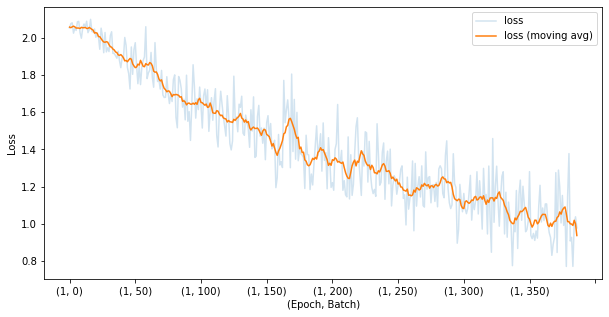

In [30]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0);

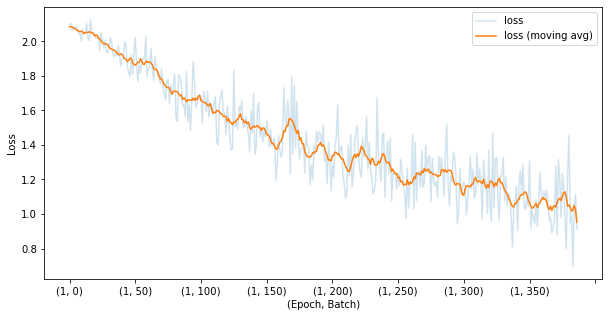

We see that our model is doing a great job of reducing loss after every batch it goes through! Let's save this model and then run it through a prediction calculator to great a dataframe for what it thinks of every image.

In [33]:
torch.save(model, "model.pth")

In [34]:
loaded_model = torch.load("model.pth")

In [31]:
eval_dataset = ImagesDataset(x_test, y_test)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [32]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 129/129 [04:04<00:00,  1.90s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ002631,0.082713,0.101350,0.145376,0.023511,0.072148,0.459435,0.057006,0.058461
ZJ009576,0.146989,0.260285,0.199693,0.013947,0.046413,0.066956,0.214054,0.051662
ZJ003552,0.131078,0.356111,0.121542,0.019655,0.021536,0.021520,0.113895,0.214663
ZJ006276,0.000877,0.002518,0.005084,0.000272,0.001302,0.989451,0.000321,0.000176
ZJ012035,0.078224,0.020153,0.503805,0.102164,0.062300,0.028057,0.009964,0.195332
...,...,...,...,...,...,...,...,...
ZJ014425,0.203806,0.146406,0.089308,0.001357,0.306163,0.049811,0.190923,0.012227
ZJ015087,0.098036,0.647535,0.071877,0.001454,0.013054,0.019395,0.117972,0.030677
ZJ000861,0.149147,0.138466,0.317138,0.011020,0.033465,0.023276,0.272592,0.054896
ZJ005637,0.154106,0.093993,0.069412,0.002149,0.023282,0.003322,0.634112,0.019625


After looking at our predictions for each label, let's take it even further by looking at the breakdown between the true and predicted labels for our train, prediction dataframe, and evaluations. 

In [38]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1869
antelope_duiker     1855
civet_genet         1817
leopard             1690
blank               1660
rodent              1510
bird                1231
hog                  734
dtype: int64

In [39]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    998
civet_genet         622
leopard             578
rodent              562
bird                433
blank               406
antelope_duiker     344
hog                 179
dtype: int64

In [41]:
print("True labels (eval):")
y_test.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    623
antelope_duiker     619
civet_genet         606
leopard             564
blank               553
rodent              503
bird                410
hog                 244
dtype: int64

In [33]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ002631    leopard
ZJ009576       bird
ZJ003552       bird
ZJ006276    leopard
ZJ012035      blank
dtype: object

Let's calculate our baseline again, just so we can compare it right next to this models performance.

In [34]:
# Baseline accuracy
eval_true = y_test.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.15114022319262493

In [35]:
# Our models accuracy score
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.6790393013100436

67% accuracy on our first model! And this one didn't take too long to process. Let's try to iterate upon this model to see what we can improve our accuracy to. But before we do that, let's take a look at a confusion matrix to see what this model looks like between our predictions and what the true values are.

# Making a Confusion Matrix to see how our model did.

Let's start this confusion matrix off by getting the appropriate library imported and taking a look at the array. It took a bit, but I was able to figure out how to make it look all pretty like with the `sns.heatmap` function.

In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
cf_matrix = confusion_matrix(eval_true, eval_predictions)

In [38]:
confusion_matrix(eval_true, eval_predictions)

array([[242,  62,  83,  30,  24,   3, 126,  49],
       [ 24, 276,  34,   0,   0,   0,  58,  18],
       [ 36,  43, 248,  31,   8,  29,  91,  67],
       [  0,   0,   5, 540,   0,   2,   0,  59],
       [ 22,  13,  33,   0, 148,   7,  14,   7],
       [  2,   8,  26,   3,   4, 515,   4,   2],
       [ 34,  44,  60,   0,   1,   0, 475,   9],
       [  9,  38,  34,  37,   4,   0,  26, 355]], dtype=int64)

In [39]:
classes = ['Monkey Prosimian', 'Civet Genet', 'Leopard', 'Rodent',
           'Bird', 'Blank', 'Antelope Duiker', 'Hog']

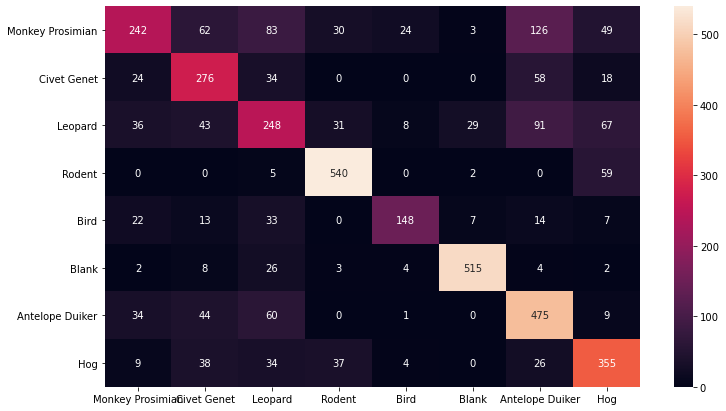

In [40]:
# Creating a confusion matrix!
df_cm2 = pd.DataFrame(cf_matrix)
plt.figure(figsize = (12,7));
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=classes, yticklabels=classes);
plt.xticks(rotation=0)
plt.show()

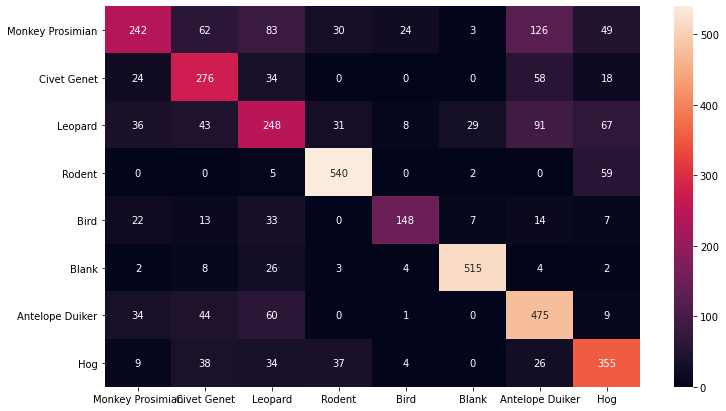

With the above heatmap we can see that our our X = Predicted values vs our Y = True values shows that our model is generally pretty good! The biggest issues we have is correctly identifying Antelope Duikers.

# Model Improvements

After successfully improving upon the baseline model, I wanted to see what I could do to keep improving our accuracy score. The first iteration I used was simply changing the epochs to 10. This next section will be iterating over the previous section, which means I'll be doing a markdown at the end of each iteration instead of between each block.

In [102]:
num_epochs = 10

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 1


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 2


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 3


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 4


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 5


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 6


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 7


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 8


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 9


  0%|          | 0/387 [00:00<?, ?it/s]

Starting epoch 10


100%|██████████| 387/387 [43:45<00:00,  6.78s/it]


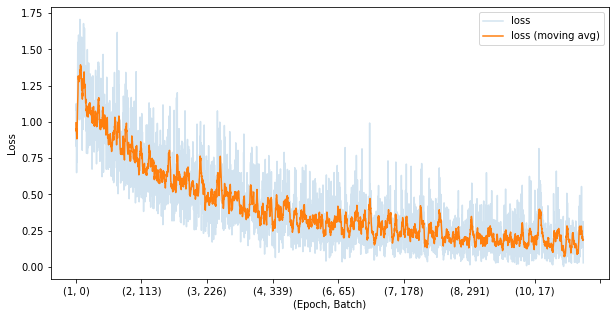

In [103]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0);

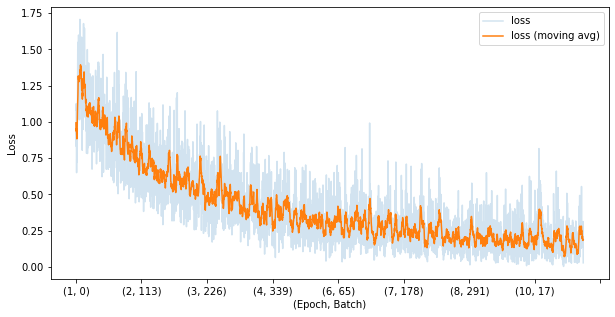

In [105]:
torch.save(model, "model10e.pth")

In [106]:
loaded_model = torch.load("model10e.pth")

In [107]:
eval_dataset1 = ImagesDataset(x_test, y_test)
eval_dataloader1 = DataLoader(eval_dataset, batch_size=32)

In [108]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 129/129 [03:52<00:00,  1.80s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ002631,0.003364,4.645763e-03,0.111706,6.175337e-04,9.221320e-04,0.873868,3.235929e-03,1.640748e-03
ZJ009576,0.011713,1.462641e-02,0.004362,1.587901e-06,6.797996e-04,0.000880,9.672822e-01,4.550288e-04
ZJ003552,0.000022,9.995131e-01,0.000017,4.340330e-07,2.974671e-07,0.000015,3.977552e-04,3.440623e-05
ZJ006276,0.000001,5.135988e-07,0.000131,3.945132e-06,3.300784e-07,0.999862,5.752919e-08,9.834739e-07
ZJ012035,0.232309,6.947710e-03,0.542068,9.675163e-04,1.677641e-04,0.000620,2.032358e-01,1.368486e-02
...,...,...,...,...,...,...,...,...
ZJ014425,0.002243,2.954070e-06,0.000438,3.586076e-05,9.927629e-01,0.004354,5.714276e-05,1.058208e-04
ZJ015087,0.001152,9.971604e-01,0.000136,5.011821e-08,5.167465e-07,0.000027,1.516160e-03,8.364677e-06
ZJ000861,0.001247,1.737866e-05,0.000436,6.373014e-09,7.846320e-06,0.000013,9.982768e-01,1.370395e-06
ZJ005637,0.000007,8.649075e-08,0.000003,1.692359e-09,1.148457e-07,0.000005,9.999838e-01,8.024790e-08


In [109]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    1869
antelope_duiker     1855
civet_genet         1817
leopard             1690
blank               1660
rodent              1510
bird                1231
hog                  734
dtype: int64

True labels (training):<br>
monkey_prosimian    1869<br>
antelope_duiker     1855<br>
civet_genet         1817<br>
leopard             1690<br>
blank               1660<br>
rodent              1510<br>
bird                1231<br>
hog                  734<br>
dtype: int64

In [110]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    684
civet_genet         655
antelope_duiker     579
leopard             565
rodent              544
blank               456
bird                405
hog                 234
dtype: int64

monkey_prosimian    684<br>
civet_genet         655<br>
antelope_duiker     579<br>
leopard             565<br>
rodent              544<br>
blank               456<br>
bird                405<br>
hog                 234<br>
dtype: int64

In [111]:
print("True labels (eval):")
y_test.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    623
antelope_duiker     619
civet_genet         606
leopard             564
blank               553
rodent              503
bird                410
hog                 244
dtype: int64

True labels (eval):<br>
monkey_prosimian    623<br>
antelope_duiker     619<br>
civet_genet         606<br>
leopard             564<br>
blank               553<br>
rodent              503<br>
bird                410<br>
hog                 244<br>
dtype: int64

In [112]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ002631             leopard
ZJ009576    monkey_prosimian
ZJ003552                bird
ZJ006276             leopard
ZJ012035               blank
dtype: object

In [114]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.861475012130034

In [115]:
cf_matrix = confusion_matrix(eval_true, eval_predictions)

In [116]:
confusion_matrix(eval_true, eval_predictions)

array([[469,  13,  52,  20,   4,   3,  47,  11],
       [  3, 374,  14,   0,   0,   1,  15,   3],
       [ 66,  10, 326,  26,   2,  23,  52,  48],
       [  2,   0,   0, 592,   0,   0,   0,  12],
       [  7,   0,   6,   3, 226,   2,   0,   0],
       [  4,   1,  15,   3,   0, 535,   5,   1],
       [ 24,   6,  27,   0,   1,   1, 562,   2],
       [  4,   1,  16,  11,   1,   0,   3, 467]], dtype=int64)

array([[469,  13,  52,  20,   4,   3,  47,  11],<br>
       [  3, 374,  14,   0,   0,   1,  15,   3],<br>
       [ 66,  10, 326,  26,   2,  23,  52,  48],<br>
       [  2,   0,   0, 592,   0,   0,   0,  12],<br>
       [  7,   0,   6,   3, 226,   2,   0,   0],<br>
       [  4,   1,  15,   3,   0, 535,   5,   1],<br>
       [ 24,   6,  27,   0,   1,   1, 562,   2],<br>
       [  4,   1,  16,  11,   1,   0,   3, 467]], dtype=int64)

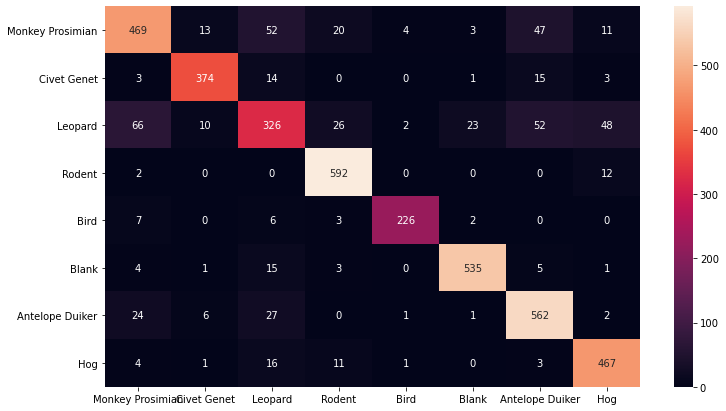

In [119]:
# Creating a confusion matrix!
df_cm2 = pd.DataFrame(cf_matrix)
plt.figure(figsize = (12,7));
sns.heatmap(cf_matrix, annot=True, fmt='', xticklabels=classes, yticklabels=classes);
plt.xticks(rotation=0)
plt.show()

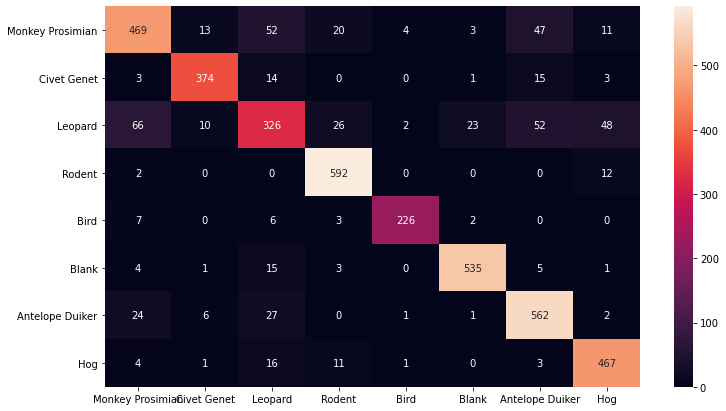

Wow what an improvement! Just changing the epochs from 1 to 10 increased our accuracy by almost 20% (from 67% to 86%). The downside is that this process took just about a day of processing to do with all of the iterations. It's looking like I'll need more time than I have available to improve on this model, but I hope to come back and try rotating/flipping the images and seeing if I can use tensorflow/keras to try and model this instead.

## Final Recommendations and Conclusion

Overall, I recommend that Taï National Park uses a convolutional neural net image classificaton model, with a potential focus on a classification system for Western Chimpanzees. (which is the main focus of the Ebola research done at Taï National Park) I also recommend that a probability threshold be set for images so that if the model only has under XX% certaintity in an image that the image will be added to a new dataset and sent to a trained analyst to certify the class of the image.

### Citations:

[Michael Schaluch](https://drivendata.co/blog/conservision-benchmark/)